## Teaching GPT multiple tasks at once with prompt engineering

In [2]:
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling, GPT2LMHeadModel, pipeline, \
                         GPT2Tokenizer
import pandas as pd
from datasets import Dataset

In [166]:
# https://www.kaggle.com/snap/amazon-fine-food-reviews?select=Reviews.csv

reviews = pd.read_csv('../data/reviews.csv')

print(reviews.shape)

reviews.head()

(96512, 3)


,Text,Summary,Score
0,Great taffy at a great price. There was a wid...,Great taffy,5
1,This taffy is so good. It is very soft and ch...,"Wonderful, tasty taffy",5
2,Right now I'm mostly just sprouting this so my...,Yay Barley,5
3,This is a very healthy dog food. Good for thei...,Healthy Dog Food,5
4,good flavor! these came securely packed... the...,fresh and greasy!,4


<AxesSubplot:title={'center':'Histogram of Review Length'}, ylabel='Frequency'>

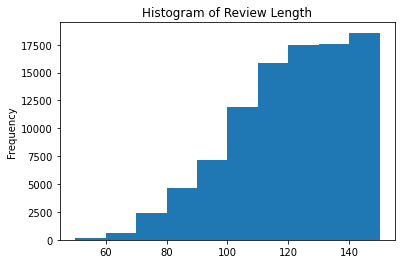

In [3]:
reviews['Text'].str.len().plot(kind='hist', title='Histogram of Review Length')

<AxesSubplot:title={'center':'Histogram of Summary Length'}, ylabel='Frequency'>

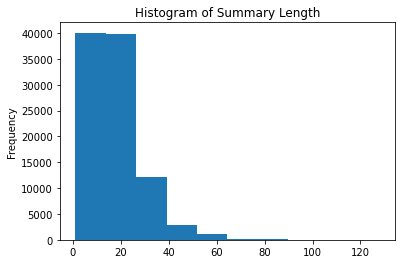

In [4]:
reviews['Summary'].str.len().plot(kind='hist', title='Histogram of Summary Length')

<AxesSubplot:title={'center':'Histogram of Summary Length'}, ylabel='Frequency'>

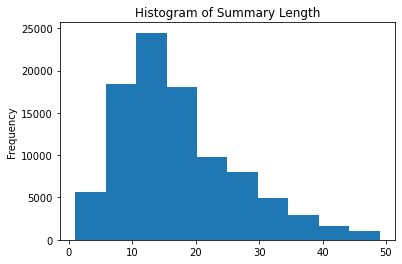

In [5]:
# remove very short and very long summaries
reviews = reviews[(reviews['Summary'].str.len() < 50)]

reviews['Summary'].str.len().plot(kind='hist', title='Histogram of Summary Length')

<AxesSubplot:>

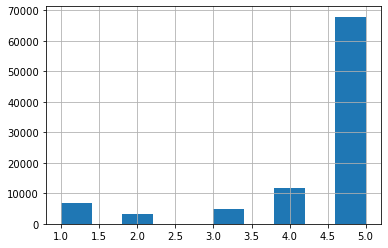

In [6]:
reviews['Score'].hist()

<AxesSubplot:>

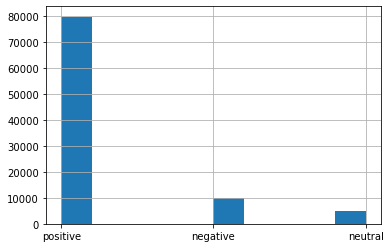

In [7]:
reviews['Sentiment'] = reviews['Score'].map(lambda x: 'positive' if x >= 4 else 'neutral' if x == 3 else 'negative')

reviews['Sentiment'].hist()


In [8]:
reviews = pd.concat(
    [
        reviews[reviews['Sentiment'] == 'positive'].sample(5000),
        reviews[reviews['Sentiment'] == 'negative'].sample(5000),
        reviews[reviews['Sentiment'] == 'neutral']
    ]
)

reviews.shape

(15003, 4)

<AxesSubplot:>

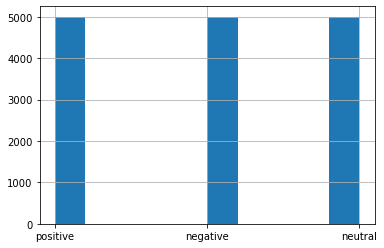

In [9]:
reviews['Sentiment'].hist()

In [10]:
MODEL = 'distilgpt2'

tokenizer = GPT2Tokenizer.from_pretrained(MODEL)

tokenizer.pad_token = tokenizer.eos_token

#add two prompts, one for each task
SENTIMENT_PROMPT = 'Sentiment Task'
SUMMARIZE_PROMPT = 'Summarize Task'
SENTIMENT_TOKEN = '\nSentiment:'
SUMMARIZE_TOKEN = '\nSummarize:'


In [11]:
reviews['sentiment_text'] = f'{SENTIMENT_PROMPT}\nReview: ' + reviews['Text'] + SENTIMENT_TOKEN +  ' ' + reviews['Sentiment'].astype(str)

reviews['summarize_text'] = f'{SUMMARIZE_PROMPT}\nReview: ' + reviews['Text'] + SUMMARIZE_TOKEN +  ' ' + reviews['Summary'].astype(str)


In [12]:
reviews['sentiment_text'].head(2).tolist()

['Sentiment Task\nReview: Great price.  Product smells great and flavors foods really well.  Perks up bland tastes.  Kicks up your cooking a notch.\nSentiment: positive',
 'Sentiment Task\nReview: The Sugar Free Peach rings were delicious.  They are almost as good as the real peach rings, just not as tart.  I just ordered a second bag!!\nSentiment: positive']

In [13]:
print('Sentiment Task\nReview: I just made this for lunch. It had almost no flavor, although it smelled heavenly for the first few minutes of cooking.\nSentiment: negative')

Sentiment Task
Review: I just made this for lunch. It had almost no flavor, although it smelled heavenly for the first few minutes of cooking.
Sentiment: negative


In [14]:
reviews['summarize_text'].head(2).tolist()

['Summarize Task\nReview: Great price.  Product smells great and flavors foods really well.  Perks up bland tastes.  Kicks up your cooking a notch.\nSummarize: Smells sweet and smoky!',
 'Summarize Task\nReview: The Sugar Free Peach rings were delicious.  They are almost as good as the real peach rings, just not as tart.  I just ordered a second bag!!\nSummarize: Almost as good as the real thing']

In [15]:
print('Summarize Task\nReview: I just made this for lunch. It had almost no flavor, although it smelled heavenly for the first few minutes of cooking.\nSummarize: Not bad, but bland')

Summarize Task
Review: I just made this for lunch. It had almost no flavor, although it smelled heavenly for the first few minutes of cooking.
Summarize: Not bad, but bland


In [16]:
reviews = reviews.sample(frac=1)

training_examples = reviews['summarize_text'].tolist() + reviews['sentiment_text'].tolist()

print(len(training_examples))

30006


In [17]:
multi_task_df = pd.DataFrame({'text': training_examples})

data = Dataset.from_pandas(multi_task_df)

def preprocess(examples):
    return tokenizer(examples['text'], truncation=True)

data = data.map(preprocess, batched=True)

data = data.train_test_split(train_size=.9)

Parameter 'function'=<function preprocess at 0x7fae18510310> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/31 [00:00<?, ?ba/s]

In [203]:
# NOTE it is common to manually add BOS (beginning of sentence) and EOS (end of sentence) tokens manually
#  to stop the model from predicting past where you want it to. I am explicitly not doing that to show you what
#  what GPT would do without those tokens. If you plan to use something like this in production, I would
#  recommend adding in those tokens manually like so:

print(multi_task_df['text'].map(lambda x: f'{tokenizer.bos_token}{x}{tokenizer.eos_token}')[0])

# you may also want to make a different start, pad and eos token so that they aren't all the default <endoftext> token
#  if you do, you may need to resize your model's tokenizer embedding

<|endoftext|>Summarize Task
Review: Decent corn. Del monte is better, and I prefer white corn, but this was ok. Quite wattery, so make sure you drain!
Summarize: Decent<|endoftext|>


In [18]:
model = GPT2LMHeadModel.from_pretrained(MODEL)

In [19]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

In [20]:
training_args = TrainingArguments(
    output_dir="./gpt2_multitask", #The output directory
    overwrite_output_dir=True, #overwrite the content of the output directory
    num_train_epochs=3, # number of training epochs
    per_device_train_batch_size=32, # batch size for training
    per_device_eval_batch_size=32,  # batch size for evaluation
    logging_steps=50,
    learning_rate=.001,
    load_best_model_at_end=True,
    evaluation_strategy='epoch',
    save_strategy='epoch'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data['train'],
    eval_dataset=data['test'],
    data_collator=data_collator
)

trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text. If text are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3001
  Batch size = 32


{'eval_loss': 5.0312018394470215,
 'eval_runtime': 740.1346,
 'eval_samples_per_second': 4.055,
 'eval_steps_per_second': 0.127}

In [21]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text. If text are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
/Users/sinanozdemir/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 27005
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 2532


Epoch,Training Loss,Validation Loss
1,2.235800,2.069937
2,1.541500,1.612124
3,1.030800,1.393526


The following columns in the evaluation set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text. If text are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3001
  Batch size = 32
Saving model checkpoint to ./gpt2_multitask/checkpoint-844
Configuration saved in ./gpt2_multitask/checkpoint-844/config.json
Model weights saved in ./gpt2_multitask/checkpoint-844/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text. If text are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3001
  Batch size = 32
Saving model checkpoint to ./gpt2_multitask/checkpoint-1688
Configuration saved in ./gpt2_multitask/checkpoint-1688/config.json
Model weights saved in ./gpt2_multitask/checkpoint-1688/pytorch_model.b

TrainOutput(global_step=2532, training_loss=1.7913735361084178, metrics={'train_runtime': 62682.6122, 'train_samples_per_second': 1.292, 'train_steps_per_second': 0.04, 'total_flos': 1186835358449664.0, 'train_loss': 1.7913735361084178, 'epoch': 3.0})

In [22]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text. If text are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3001
  Batch size = 32


{'eval_loss': 1.3935256004333496,
 'eval_runtime': 759.1195,
 'eval_samples_per_second': 3.953,
 'eval_steps_per_second': 0.124,
 'epoch': 3.0}

In [23]:
trainer.save_model()

Saving model checkpoint to ./gpt2_multitask
Configuration saved in ./gpt2_multitask/config.json
Model weights saved in ./gpt2_multitask/pytorch_model.bin


In [24]:
loaded_model = GPT2LMHeadModel.from_pretrained('./gpt2_multitask')

generator = pipeline('text-generation', model=loaded_model, tokenizer=tokenizer)

loading configuration file ./gpt2_multitask/config.json
Model config GPT2Config {
  "_name_or_path": "distilgpt2",
  "_num_labels": 1,
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 6,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "torch_dtype": "f

In [88]:
text_sample, score, summary = reviews.sample(1)[['Text', 'Sentiment', 'Summary']].values[0]

print(text_sample)
print(score)
print(summary)

num_tokens = len(tokenizer(text_sample)['input_ids'])
num_tokens

Our family loves these udon type noodles, thick and chewy. Very spicey so we only use half a pack of seasoning for each.
positive
SPICY!


29

In [89]:
sentiment_text_sample = f'{SENTIMENT_PROMPT}\nReview: {text_sample}{SENTIMENT_TOKEN}'
summarize_text_sample = f'{SUMMARIZE_PROMPT}\nReview: {text_sample}{SUMMARIZE_TOKEN}'

In [90]:
print(sentiment_text_sample)

Sentiment Task
Review: Our family loves these udon type noodles, thick and chewy. Very spicey so we only use half a pack of seasoning for each.
Sentiment:


In [91]:
print(summarize_text_sample)

Summarize Task
Review: Our family loves these udon type noodles, thick and chewy. Very spicey so we only use half a pack of seasoning for each.
Summarize:


In [92]:
for generated_text in generator(
    sentiment_text_sample, 
    num_return_sequences=3, 
    max_length=num_tokens + 1, 
    temperature=0.2
):
    print(generated_text['generated_text'])
    print('----')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 39, but ``max_length`` is set to 30. This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.


Sentiment Task
Review: Our family loves these udon type noodles, thick and chewy. Very spicey so we only use half a pack of seasoning for each.
Sentiment: positive
----
Sentiment Task
Review: Our family loves these udon type noodles, thick and chewy. Very spicey so we only use half a pack of seasoning for each.
Sentiment: positive
----
Sentiment Task
Review: Our family loves these udon type noodles, thick and chewy. Very spicey so we only use half a pack of seasoning for each.
Sentiment: positive
----


In [99]:
for generated_text in generator(
    summarize_text_sample, 
    num_return_sequences=3, 
    max_length=num_tokens + 20, 
    temperature=0.7,
    beams=3, 
):
    print(generated_text['generated_text'])
    print('----')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Summarize Task
Review: Our family loves these udon type noodles, thick and chewy. Very spicey so we only use half a pack of seasoning for each.
Summarize: Great noodles! Fast delivery! Spicy
----
Summarize Task
Review: Our family loves these udon type noodles, thick and chewy. Very spicey so we only use half a pack of seasoning for each.
Summarize: Very spicy! Too much seasoning! Too
----
Summarize Task
Review: Our family loves these udon type noodles, thick and chewy. Very spicey so we only use half a pack of seasoning for each.
Summarize: Very Spicy! Spicy! Our
----


In [156]:
def process(text):
    sentiment_text_sample = f'{SENTIMENT_PROMPT}\nReview: {text}{SENTIMENT_TOKEN}'
    summarize_text_sample = f'{SUMMARIZE_PROMPT}\nReview: {text}{SUMMARIZE_TOKEN}'
    
    print('----Summaries----')
    num_tokens = len(tokenizer(summarize_text_sample)['input_ids'])
    for generated_text in generator(
        summarize_text_sample, 
        num_return_sequences=3,
        beams=5, 
        max_length=num_tokens + 10, 
        temperature=0.7
    ):
        print(generated_text['generated_text'].split(SUMMARIZE_TOKEN)[1])
    print('----Sentiment----')
    num_tokens = len(tokenizer(sentiment_text_sample)['input_ids'])
    for generated_text in generator(
        sentiment_text_sample, 
        num_return_sequences=1, 
        max_length=num_tokens + 1, 
        temperature=0.2
    ):
        print(generated_text['generated_text'].split(SENTIMENT_TOKEN)[1])

In [161]:
process('I am a big fan of this dog food. Very yummy and my dog loved it too!')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


----Summaries----


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 Yum! Yum! Yum! Y
 Yummy and healthy! My dog loved it!
 Yummy and healthy! Best food I have ever
----Sentiment----
 positive


In [165]:
# a review I saw on ubereats while I was ordering dinner last night
process('All kinds of nice flavors and textures to enjoy in their rice bowls, loved it!')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


----Summaries----


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 Great stuff!  Very good rice!  Best
 Best rice product on the market! Goes great with
 Great taste, easy to prepare and easy to prepare
----Sentiment----
 positive


In [94]:
# Trying with a non-finetuned GPT2 to see the style difference

In [95]:
non_fintuned_generator = pipeline(
    'text-generation', model=GPT2LMHeadModel.from_pretrained('gpt2'), tokenizer=tokenizer
)

loading configuration file https://huggingface.co/gpt2/resolve/main/config.json from cache at /Users/sinanozdemir/.cache/huggingface/transformers/fc674cd6907b4c9e933cb42d67662436b89fa9540a1f40d7c919d0109289ad01.7d2e0efa5ca20cef4fb199382111e9d3ad96fd77b849e1d4bed13a66e1336f51
Model config GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-gen

In [96]:
for generated_text in non_fintuned_generator(sentiment_text_sample, num_return_sequences=5, max_length=num_tokens + 1):
    print(generated_text['generated_text'])
    print('-------')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 39, but ``max_length`` is set to 30. This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.


Sentiment Task
Review: Our family loves these udon type noodles, thick and chewy. Very spicey so we only use half a pack of seasoning for each.
Sentiment: Great
-------
Sentiment Task
Review: Our family loves these udon type noodles, thick and chewy. Very spicey so we only use half a pack of seasoning for each.
Sentiment: These
-------
Sentiment Task
Review: Our family loves these udon type noodles, thick and chewy. Very spicey so we only use half a pack of seasoning for each.
Sentiment: Love
-------
Sentiment Task
Review: Our family loves these udon type noodles, thick and chewy. Very spicey so we only use half a pack of seasoning for each.
Sentiment: The
-------
Sentiment Task
Review: Our family loves these udon type noodles, thick and chewy. Very spicey so we only use half a pack of seasoning for each.
Sentiment: This
-------


In [97]:
for generated_text in non_fintuned_generator(summarize_text_sample, num_return_sequences=3, max_length=num_tokens + 20):
    print(generated_text['generated_text'])
    print('----')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Summarize Task
Review: Our family loves these udon type noodles, thick and chewy. Very spicey so we only use half a pack of seasoning for each.
Summarize: We use three whole ingredients here, they
----
Summarize Task
Review: Our family loves these udon type noodles, thick and chewy. Very spicey so we only use half a pack of seasoning for each.
Summarize: We used these with everything from our "
----
Summarize Task
Review: Our family loves these udon type noodles, thick and chewy. Very spicey so we only use half a pack of seasoning for each.
Summarize: These will be great if you are wanting
----


In [98]:
for generated_text in non_fintuned_generator(f'Summarization Task\n{text_sample}\nTL;DR:', num_return_sequences=3, max_length=num_tokens + 20):
    print(generated_text['generated_text'])
    print('----')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Summarization Task
Our family loves these udon type noodles, thick and chewy. Very spicey so we only use half a pack of seasoning for each.
TL;DR:
For the "tummy-sushi",
----
Summarization Task
Our family loves these udon type noodles, thick and chewy. Very spicey so we only use half a pack of seasoning for each.
TL;DR: I will NEVER buy this, they do not work
----
Summarization Task
Our family loves these udon type noodles, thick and chewy. Very spicey so we only use half a pack of seasoning for each.
TL;DR: The following Udon noodles are ready to cook.
----
